In [0]:
"""
This notebook utilizes Natural Language Processing to classifiy whether tweets are about a disaster or not.

Data taken from Kaggle - Natural Language Processing with Disaster Tweets
"""

'\nThis notebook utilizes Natural Language Processing to classifiy whether tweets are about a disaster or not.\n\nData taken from Kaggle - Natural Language Processing with Disaster Tweets\n'

In [0]:

!pip install pip --upgrade
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade
!pip install tensorflow

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--
   ━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.1/1.8 MB 4.6 MB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.8 MB 7.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━ 0.9/1.8 MB 8.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━ 1.4/1.8 MB 10.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.8/1.8 MB 11.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restart

In [0]:
import pandas as pd
import tensorflow as tf
import keras_core as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from pyspark.sql.types import BooleanType, StringType, ArrayType, StructType, StructField, DoubleType
import re
import string

from pyspark.sql.functions import col, udf, lower, split, when

from nltk.corpus import stopwords, words
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag, ne_chunk

from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer, VectorAssembler, CountVectorizer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2024-07-09 14:47:57.859026: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 14:47:57.865440: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-09 14:47:57.885482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-09 14:47:57.915992: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-09 14:47:57.916051: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-09 14:47:57.935175: I tensorflow/core/platform/cpu_feature_guard.cc:

Using TensorFlow backend


In [0]:
train_file_path = "default.nlp_train_8_csv"
test_file_path = "default.nlp_test_6_csv"

In [0]:
# Load data and remove the nulls
train_df = spark.table(train_file_path).filter(col('text').isNotNull()).filter(col('target').isNotNull())
test_df = spark.table(test_file_path).filter(col('text').isNotNull())

In [0]:
display(train_df)

id keyword location text target 1 null null Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all 1 4 null null Forest fire near La Ronge Sask. Canada 1 5 null null All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 1 6 null null 13,000 people receive #wildfires evacuation orders in California 1 7 null null Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 1 8 null null #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires 1 10 null null #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas 1 13 null null I'm on top of the hill and I can see a fire in the woods... 1 14 null null There's an emergency evacuation happening now in the building across the street 1 15 null null I'm afraid that the tornado is coming to our area... 1 16 null null Three people died from the heat wave so far 1 17 null null Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding 1 18 null null #raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count 1 19 null null #Flood in Bago Myanmar #We arrived Bago 1 20 null null Damage to school bus on 80 in multi car crash #BREAKING 1 23 null null What's up man? 0 24 null null I love fruits 0 25 null null Summer is lovely 0 26 null null My car is so fast 0 28 null null What a goooooooaaaaaal!!!!!! 0 31 null null this is ridiculous.... 0 32 null null London is cool ;) 0 33 null null Love skiing 0 34 null null What a wonderful day! 0 36 null null LOOOOOOL 0 37 null null No way...I can't eat that shit 0 38 null null Was in NYC last week! 0 39 null null Love my girlfriend 0 40 null null Cooool :) 0 41 null null Do you like pasta? 0 44 null null The end! 0 48 ablaze Birmingham @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C 1 49 ablaze Est. September 2012 - Bristol We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw 0 50 ablaze AFRICA #AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi 1 52 ablaze Philadelphia, PA Crying out for more! Set me ablaze 0 53 ablaze London, UK On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N 0 54 ablaze Pretoria @PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season. 0 55 ablaze World Wide!! INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA 1 56 ablaze null Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende... http://t.co/wDUEaj8Q4J 1 57 ablaze Paranaque City Ablaze for you Lord :D 0 59 ablaze Live On Webcam Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw 0 62 ablaze milky way Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ?? 0 63 ablaze null SOOOO PUMPED FOR ABLAZE ???? @southridgelife 0 64 ablaze null I wanted to set Chicago ablaze with my preaching... But not my hotel! http://t.co/o9qknbfOFX 0 65 ablaze null I gained 3 followers in the last week. You? Know your stats and grow with http://t.co/TIyUliF5c6 0 66 ablaze GREENSBORO,NORTH CAROLINA How the West was burned: Thousands of wildfires ablaze in California alone http://t.co/vl5TBR3wbr 1 67 ablaze null Building the perfect tracklist to life leave the streets ablaze 0 68 ablaze Live On Webcam Check these out: http://t.co/rOI2NSmEJJ http://t.co/3Tj8ZjiN21 http://t.co/YDUiXEfIpE http://t.co/LxTjc87KLS #nsfw 0 71 ablaze England. First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least. 0 73 ablaze Sheffield Township, Ohio Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRh

In [0]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('words')

# Initialize stopwords, lemmatizer, and word list
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
word_list = set(words.words())

# Broadcast stopwords and word list
broadcast_stop_words = spark.sparkContext.broadcast(stop_words)
broadcast_word_list = spark.sparkContext.broadcast(word_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# Clean Data

In [0]:
class data_cleaning():
    def __init__(self, broadcast_stop_words, broadcast_word_list):
        self.stop_words = broadcast_stop_words.value
        self.lemmatizer = WordNetLemmatizer()
        self.word_list = broadcast_word_list.value
    
    def contains_url(self, text):
        url_pattern = re.compile(r'http[s]?://')
        return bool(url_pattern.search(text))
    
    def remove_urls(self, text):
        url_pattern = re.compile(r'http[s]?://\S+')
        return url_pattern.sub('', text)
    
    # Remove the pound sign from the hashtags, but find the words within the hashtag
    def split_hashtag(self, hashtag):
        def segment(text, word_list):
            n = len(text)
            dp = [None] * (n + 1)
            dp[0] = []
            for i in range(1, n + 1):
                for j in range(i):
                    word = text[j:i].lower()
                    if word in word_list and dp[j] is not None:
                        if dp[i] is None or len(dp[j]) + 1 < len(dp[i]):
                            dp[i] = dp[j] + [word]
            return dp[-1] if dp[-1] is not None else [text]

        words = hashtag.split()
        result = []
        for word in words:
            if word.startswith("#"):
                word = word[1:]
                split_words_in_tag = segment(word, self.word_list)
                result.append(" ".join(split_words_in_tag))
            else:
                result.append(word)
        return " ".join(result)

    def process_text(self, text):
        hashtag_pattern = re.compile(r'#\w+')
        hashtags = hashtag_pattern.findall(text)
        text = hashtag_pattern.sub('', text)
        processed_hashtags = " ".join([self.split_hashtag(tag) for tag in hashtags])
        return text + " " + processed_hashtags
    
    def remove_punctuation(self, text):
        return text.translate(str.maketrans('', '', string.punctuation))
    
    def remove_stopwords(self, text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in self.stop_words]
        return ' '.join(filtered_words)
    
    # Prepare data for logistic regression
    
    def lemmatize_tokens(self, tokens):
        return [self.lemmatizer.lemmatize(token) for token in tokens]

    def pos_tag_tokens(self, tokens):
        return pos_tag(tokens)

    def clean(self, df):
        contains_url_udf = udf(self.contains_url, BooleanType())
        remove_urls_udf = udf(self.remove_urls, StringType())
        process_text_udf = udf(self.process_text, StringType())
        remove_punctuation_udf = udf(self.remove_punctuation, StringType())
        remove_stopwords_udf = udf(self.remove_stopwords, StringType())
        lemmatize_tokens_udf = udf(self.lemmatize_tokens, ArrayType(StringType()))

        pos_tag_schema = ArrayType(StructType([
            StructField("word", StringType(), False),
            StructField("pos", StringType(), False)
        ]))

        pos_tag_tokens_udf = udf(self.pos_tag_tokens, pos_tag_schema)

        # Create a flag column for if a row contains a url
        df = df.withColumn("contains_url", contains_url_udf(col("text")))

        # Remove urls from the text
        df = df.withColumn("text", remove_urls_udf(col("text")))

        # Remove the pound sign from hashtags, but split the hashtag into words within the hashtags
        df = df.withColumn("text", process_text_udf(col("text")))

        # Convert all letters to lowercase
        df = df.withColumn("text", lower(col("text")))

        # Remove punctuation from the text
        df = df.withColumn("text", remove_punctuation_udf(col("text")))

        # Remove all words that don't add importance
        df = df.withColumn("text", remove_stopwords_udf(col("text")))

        # Turn the text into arrays of words
        df = df.withColumn("token", split(col("text"), " "))

        # Break words down with lemmatization
        df = df.withColumn("token", lemmatize_tokens_udf(col("token")))

        # Tag the parts of speech
        df = df.withColumn("pos_tag", pos_tag_tokens_udf(col("token")))
        return df

In [0]:
class MLPipeline:
    def __init__(self):
        self.tokenizer = Tokenizer(inputCol="text", outputCol="words")
        self.vectorizer = CountVectorizer(inputCol="words", outputCol="raw_features")
        self.idf = IDF(inputCol="raw_features", outputCol="features")
        self.indexer = StringIndexer(inputCol="target", outputCol="label")
        self.lr = LogisticRegression(featuresCol="features", labelCol="label")
        self.pipeline = Pipeline(stages=[self.tokenizer, self.vectorizer, self.idf, self.indexer, self.lr])
        self.model = None

    def train_and_evaluate(self, df):
        train_df, test_df = df.randomSplit([0.8, 0.2], seed=12345)

        # Hyperparameter Tuning
        paramGrid = ParamGridBuilder().addGrid(self.vectorizer.vocabSize, [1000, 5000, 10000]).addGrid(self.lr.regParam, [0.1, 0.01]).build()

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

        # Cross Validation
        crossval = CrossValidator(estimator=self.pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=3,
                                  parallelism=2)

        spark.conf.set("spark.databricks.widget.display", "false")

        self.model = crossval.fit(train_df)
        predictions = self.model.transform(test_df)

        # Evaluate
        accuracy = evaluator.evaluate(predictions)
        print(f"Cross-validated accuracy: {accuracy}")

        self.display_confusion_matrix(predictions)

        self.display_top_words()
        return self.model

    def predict(self, df):
        if self.model is None:
            raise ValueError("Model is not trained. Call train_and_evaluate first.")
        predictions = self.model.transform(df)
        return predictions
    
    def display_confusion_matrix(self, predictions):
        pandas_df = predictions.select("label", "prediction").toPandas()

        y_true = pandas_df["label"]
        y_pred = pandas_df["prediction"]
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix Heatmap")
        plt.show()
        
    def display_top_words(self):
        # Extract feature importances
        coefficients = self.model.bestModel.stages[-1].coefficients.toArray()
        vocab = self.model.bestModel.stages[1].vocabulary

        word_coefficients = [(vocab[i], coefficients[i]) for i in range(len(vocab))]
        word_coefficients = sorted(word_coefficients, key=lambda x: x[1], reverse=True)

        print("Top words associated with target=1:")
        for word, coef in word_coefficients[:10]:
            print(f"{word}: {coef}")

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Cross-validated accuracy: 0.7927170868347339


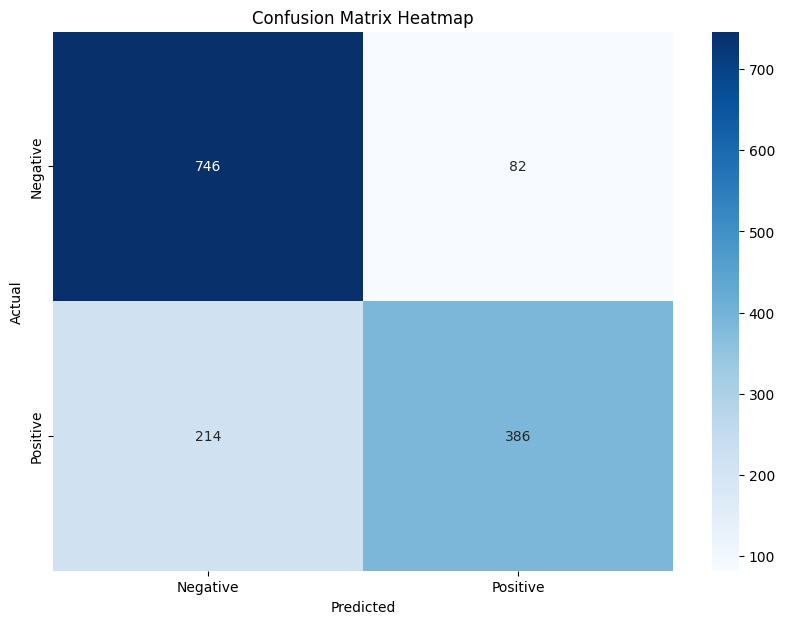

Top words associated with target=1:
typhoon: 0.28372028363533985
earthquake: 0.25531091412629103
evacuated: 0.24637390725287062
derailment: 0.23643637796405498
bombing: 0.2357077340159286
fires: 0.2331462612123163
wildfire: 0.23005589459353892
hiroshima: 0.22915260377900765
poor: 0.22824856896042237
casualties: 0.22399488037028473


In [0]:
cleaner = data_cleaning(broadcast_stop_words, broadcast_word_list)
ml_pipeline = MLPipeline()

# Clean the data
cleaned_train_df = cleaner.clean(train_df)
cleaned_test_df = cleaner.clean(test_df)

model = ml_pipeline.train_and_evaluate(cleaned_train_df)

In [0]:
display(cleaned_test_df)

id keyword location text contains_url token pos_tag 0 null null happened terrible car crash false List(happened, terrible, car, crash) List(List(happened, VBN), List(terrible, JJ), List(car, NN), List(crash, NN)) 2 null null heard different cities stay safe everyone earthquake false List(heard, different, city, stay, safe, everyone, earthquake) List(List(heard, RB), List(different, JJ), List(city, NN), List(stay, NN), List(safe, JJ), List(everyone, NN), List(earthquake, NN)) 3 null null forest fire spot pond geese fleeing across street cannot save false List(forest, fire, spot, pond, goose, fleeing, across, street, cannot, save) List(List(forest, JJS), List(fire, NN), List(spot, NN), List(pond, NN), List(goose, NN), List(fleeing, VBG), List(across, IN), List(street, NN), List(cannot, NNS), List(save, VB)) 9 null null apocalypse lighting p oka ne wildfire false List(apocalypse, lighting, p, oka, ne, wildfire) List(List(apocalypse, NN), List(lighting, VBG), List(p, JJ), List(oka, JJ), List(ne, NN), List(wildfire, NN)) 11 null null typhoon soudelor kills 28 china taiwan false List(typhoon, soudelor, kill, 28, china, taiwan) List(List(typhoon, NN), List(soudelor, NN), List(kill, VB), List(28, CD), List(china, NNS), List(taiwan, VBP)) 12 null null shakingits earthquake false List(shakingits, earthquake) List(List(shakingits, NNS), List(earthquake, NN)) 21 null null theyd probably still show life arsenal yesterday eh eh false List(theyd, probably, still, show, life, arsenal, yesterday, eh, eh) List(List(theyd, NN), List(probably, RB), List(still, RB), List(show, VB), List(life, NN), List(arsenal, JJ), List(yesterday, NN), List(eh, VBZ), List(eh, NN)) 22 null null hey false List(hey) List(List(hey, NN)) 27 null null nice hat false List(nice, hat) List(List(nice, JJ), List(hat, NN)) 29 null null fuck false List(fuck) List(List(fuck, NN)) 30 null null dont like cold false List(dont, like, cold) List(List(dont, NN), List(like, IN), List(cold, NN)) 35 null null nooooooooo dont false List(nooooooooo, dont) List(List(nooooooooo, NNS), List(dont, NN)) 42 null null dont tell false List(dont, tell) List(List(dont, NN), List(tell, NN)) 43 null null false List() List(List(, NN)) 45 null null awesome false List(awesome) List(List(awesome, NN)) 46 ablaze London birmingham wholesale market ablaze bbc news fire breaks birminghams wholesale market true List(birmingham, wholesale, market, ablaze, bbc, news, fire, break, birmingham, wholesale, market) List(List(birmingham, JJ), List(wholesale, JJ), List(market, NN), List(ablaze, NN), List(bbc, JJ), List(news, NN), List(fire, NN), List(break, NN), List(birmingham, JJ), List(wholesale, JJ), List(market, NN)) 47 ablaze Niall's place | SAF 12 SQUAD | sunkxssedharry wear shorts race ablaze false List(sunkxssedharry, wear, short, race, ablaze) List(List(sunkxssedharry, NN), List(wear, WRB), List(short, JJ), List(race, NN), List(ablaze, NN)) 51 ablaze NIGERIA toke makinwaûªs marriage crisis sets nigerian twitter ablaze previously yin v true List(toke, makinwaûªs, marriage, crisis, set, nigerian, twitter, ablaze, previously, yin, v) List(List(toke, NN), List(makinwaûªs, NN), List(marriage, NN), List(crisis, NN), List(set, VBN), List(nigerian, JJ), List(twitter, NN), List(ablaze, NN), List(previously, RB), List(yin, VBZ), List(v, NN)) 58 ablaze Live On Webcam check n f w true List(check, n, f, w) List(List(check, NN), List(n, CC), List(f, NN), List(w, NN)) 60 ablaze Los Angeles, Califnordia psa iûªm splitting personalities false List(psa, iûªm, splitting, personality) List(List(psa, NN), List(iûªm, NN), List(splitting, NN), List(personality, NN)) 69 ablaze threeonefive. beware world ablaze sierra leone amp guap false List(beware, world, ablaze, sierra, leone, amp, guap) List(List(beware, NN), List(world, NN), List(ablaze, NN), List(sierra, VBP), List(leone, NN), List(amp, NN), List(guap, NN)) 70 ablaze Washington State burning man ablaze turban diva via etsy true List(burning, man, ablaze, turban, diva, 

In [0]:
# predictions = ml_pipeline.predict(cleaned_test_df)

# predictions_final = predictions.withColumnRenamed('prediction', 'target').select('id', 'target')
# display(predictions_final)